In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


There will 6 sections to this classification task:

* Reading the data
* Visualizing the data
* Training the K-nearest neighbors model
* Evaluating our model
* Fine tuning our model
* Data augmentation (more on this later)

## Section 1 - Reading the data

Currently our data resides in CSV file(s).

Using pandas, we can read the CSV file(s) to a more usable format i.e. `Pandas Dataframe`

In [2]:
mnist_train = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")
mnist_test = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")

In [3]:
mnist_train

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As evident from the dataframe, our training set consists of 60,000 rows each containing 785 columns.

One column corresponds to the `label` of the digit (which digit is it?)

Rest 784 columns correspond to the pixel intensities of a handwritten digit image. Each handwritten digit is an image of dimensions 28 x 28 pixels stretched out to an array of length 784.

Now, since this will be a supervised learning task, we seperate the labels from the pixel intensities/digits data...

In [4]:
y_train = mnist_train["label"].copy().to_numpy()
X_train = mnist_train.drop(columns=["label"]).to_numpy()

print("The training digits data:\n", X_train)
print("Digit labels: ", y_train)

# Similarly for the test set
y_test = mnist_test["label"].copy().to_numpy()
X_test = mnist_test.drop(columns=["label"]).to_numpy()

The training digits data:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Digit labels:  [5 0 4 ... 5 6 8]


After getting the digits data array and the corresponding labels we move on to visualize how the data looks.

## Section 2 - Visualizing the Data

Since any instance of the data is an array of length 784 (28 x 28 image).
We plot the digit using `matplotlib` by reshaping the array of length 784.

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

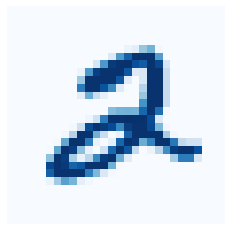

In [6]:
some_digit_data = X_train[5]
some_digit_image = some_digit_data.reshape(28, 28)

# imshow plots the matrix
plt.imshow(some_digit_image, cmap=plt.cm.Blues)
plt.axis("off")
plt.show()

Okay so it's a 2.

Checking the corresponding label...

In [7]:
print(y_train[5])

2


Just to get some more feel of the data, lets create a function to plot digits

In [8]:
def plot_digits(data, row_size=5):
    for i in range(len(data)):
        ax = plt.subplot(row_size, row_size, i+1)
        
        digit = data[i]
        digit_image = digit.reshape(28, 28)
        
        plt.imshow(digit_image, cmap=plt.cm.Blues)
        plt.axis("off")

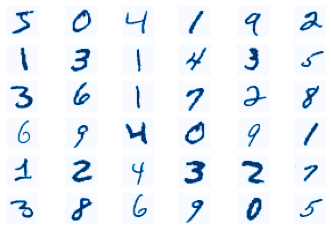

In [9]:
plot_digits(X_train[:36], row_size=6)
plt.show()

Hmm, people do write the things badly.

## Section 3 - Training the K-Nearest Neighbors Model



In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# train the classifier
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [12]:
# Predicting on some digit
knn.predict([some_digit_data])

array([2])

Seems right!

Now let's evaluate this simple model

## Section 4 - Evaluating our model

There are various ways to evaluate any classifier. One way is to build a **confusion matrix** which stores the information regarding the actual labels vs the classifier predicted labels.

But to build a confusion matrix, we need the classifications from our classifier. Instead of using the test set for that, we will use a technique called **Cross Validation** on the training set.
Basically, it reserves a small part of the training set for validation of the model, while it trains on rest of the training set.

Okay enough talking, let me show you...

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# our predictions using cross validation on training set
knn_preds = cross_val_predict(knn, X_train, y_train, cv=3)

In [14]:
knn_preds

array([5, 0, 4, ..., 5, 6, 8])

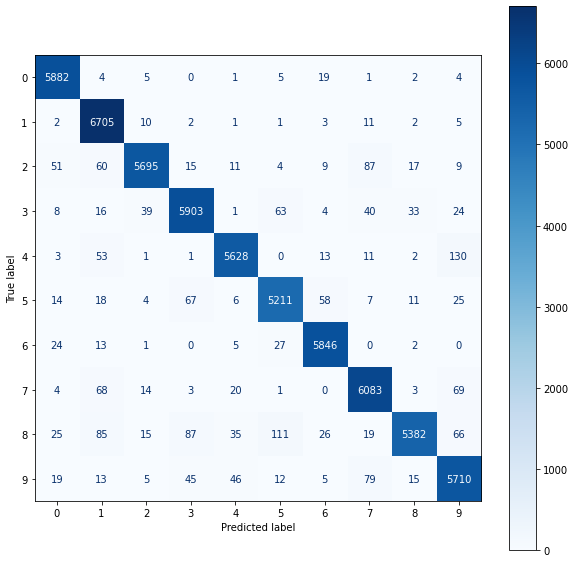

In [15]:
# Build the confusion matrix
cf_mat = confusion_matrix(y_train, knn_preds)

# Display it
cm_fig, cm_ax = plt.subplots(figsize=(10, 10))
cf_mat_disp = ConfusionMatrixDisplay(cf_mat)
cf_mat_disp.plot(ax=cm_ax, cmap=plt.cm.Blues)
plt.show()

Take some time to understand the structure of this matrix.
It shows the number of instances classified correctly/incorrectly.

For example, the cell (5, 5) shows that classifier correctly classified 5211 instances whose class was '5'. Similarly the cell (5, 6) shows that the classifier incorrectly classified 58 instances of class '5' as class '6'.

A perfect classifier will have a confusion matrix, where all the cells except the main diagonal has the value 0.

In [18]:
from sklearn.metrics import classification_report

def class_report(y, y_preds):
    print("\nClassification report:\n\n",
          classification_report(y, y_preds, digits=6))

To examine the classsification report of our KNN model, we use this function...

In [19]:
class_report(y_train, knn_preds)


Classification report:

               precision    recall  f1-score   support

           0   0.975133  0.993078  0.984023      5923
           1   0.953092  0.994512  0.973361      6742
           2   0.983762  0.955858  0.969609      5958
           3   0.964070  0.962812  0.963441      6131
           4   0.978102  0.963369  0.970680      5842
           5   0.958786  0.961262  0.960022      5421
           6   0.977102  0.987834  0.982438      5918
           7   0.959766  0.970950  0.965326      6265
           8   0.984092  0.919843  0.950883      5851
           9   0.945051  0.959825  0.952381      5949

    accuracy                       0.967417     60000
   macro avg   0.967896  0.966934  0.967216     60000
weighted avg   0.967676  0.967417  0.967345     60000



As we can see, currently our barebones KNN model has ~ 96% accuracy in classifying the digits. Can we achieve more?

## Section 5 - Fine tuning our model

We will be using **Grid Searching Technique** on our KNN model, to find the hyperparameters which may result in increased accuracy.

Since Grid Search may take long time in finding good hyperparameters I'll comment that code out...

In [20]:
# from sklearn.model_selection import GridSearchCV

# space = [
#     {"weights": ["uniform", "distance"],
#      "n_neighbors": [2, 3, 5, 7]
#     }
# ]

# knn_grid_search = GridSearchCV(knn, param_grid=space, cv=3, scoring="accuracy", n_jobs=2)
# knn_grid_search.fit(X_train, y_train)

The `best_estimator_` method tells us which model (with it's hyperparameters) performed best.

In [21]:
# print(knn_grid_search.best_estimator_)

The results from Grid Search to be printed.

In [23]:
# convert the cv_results dict into pandas dataframe
# cvres = pd.DataFrame.from_dict(knn_grid_search.cv_results_)
# cvres

This search gives us the best estimator/classifier as:

**KNeighborsClassifier(n_neighbors=3, weights='distance')**

So we use this as our fine tuned model.

In [24]:
knn_tuned = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

Let's measure the accuracy of our fine tuned model on the test set!

In [25]:
y_test_preds = knn_tuned.predict(X_test)

In [26]:
class_report(y_test, y_test_preds)


Classification report:

               precision    recall  f1-score   support

           0   0.973027  0.993878  0.983342       980
           1   0.965899  0.998238  0.981802      1135
           2   0.984205  0.966085  0.975061      1032
           3   0.966303  0.965347  0.965825      1010
           4   0.976313  0.965377  0.970814       982
           5   0.964126  0.964126  0.964126       892
           6   0.981289  0.985386  0.983333       958
           7   0.962246  0.966926  0.964580      1028
           8   0.987166  0.947639  0.966998       974
           9   0.958457  0.960357  0.959406      1009

    accuracy                       0.971700     10000
   macro avg   0.971903  0.971336  0.971529     10000
weighted avg   0.971811  0.971700  0.971663     10000



Aha! We found better hyperparameters and increased the accuracy of our model to 97%.

## Section 6 - Data Augmentation

One last thing before ending this notebook is to know about data augmentation/training set expansion.
This is a technique to artificially grow the training set, by modifying the existing training set data.

For example, one way to increase the training set data is to:

Shift image in any/all of the four directions (Left, Right, Up, Down) by 2-5 pixels. Now for each image in the training set, create four shifted copies and add them to the existing training set.

**NOTE**: For the sake of time, the code below does this data augmentation for only 100 instances of the training set.

In [27]:
from scipy.ndimage import shift

# tuples for directions
LEFT = [0, -1]
RIGHT = [0, 1]
UP = [-1, 0]
DOWN = [1, 0]

# New training set will extend old one
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

# loop over training set
for index, digit in enumerate(X_train[:100]):
    # 1) Reshape the digit to a 28 x 28 array
    # 2) Create 4 shifted copies and reshape it to 784 x 1 array
    # 3) Add them to training set and also the labels
    dig = digit.reshape(28, 28)
    dig_label = y_train[index]
    
    digit_left = shift(dig, LEFT, cval=0).reshape(784)
    digit_right = shift(dig, RIGHT, cval=0).reshape(784)
    digit_up = shift(dig, UP, cval=0).reshape(784)
    digit_down = shift(dig, DOWN, cval=0).reshape(784)
    
    X_train_aug = np.vstack((X_train_aug, digit_left))
    X_train_aug = np.vstack((X_train_aug, digit_right))
    X_train_aug = np.vstack((X_train_aug, digit_up))
    X_train_aug = np.vstack((X_train_aug, digit_down))
    
    for _ in range(4):
        y_train_aug = np.hstack((y_train_aug, [dig_label]))
    
    
print(X_train_aug.shape)
print(y_train_aug.shape)

(60400, 784)
(60400,)


As evident, the training set size increases from 60,000 to 60,400 due to data augmentation on 100 instances.

Thank you!